In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import re

In [41]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import hamming_loss, accuracy_score, precision_score,recall_score,f1_score

In [42]:
questions_df = pd.read_csv("input/Questions.csv", encoding='iso-8859-1')
questions_df.head(5)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


In [43]:
tags_df = pd.read_csv("input/Tags.csv", encoding='iso-8859-1')
tags_df.head(5)

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


In [44]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85085 entries, 0 to 85084
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            85085 non-null  int64  
 1   OwnerUserId   84101 non-null  float64
 2   CreationDate  85085 non-null  object 
 3   Score         85085 non-null  int64  
 4   Title         85085 non-null  object 
 5   Body          85085 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ MB


In [45]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244228 entries, 0 to 244227
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      244228 non-null  int64 
 1   Tag     244228 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [46]:
grouped_tags = tags_df['Tag'].value_counts().to_frame().reset_index()
grouped_tags

,Tag,count
0,r,13236
1,regression,10959
2,machine-learning,6089
3,time-series,5559
4,probability,4217
...,...,...
1310,fmincon,1
1311,doc2vec,1
1312,sympy,1
1313,adversarial-boosting,1


In [47]:
grouped_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     1315 non-null   object
 1   count   1315 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.7+ KB


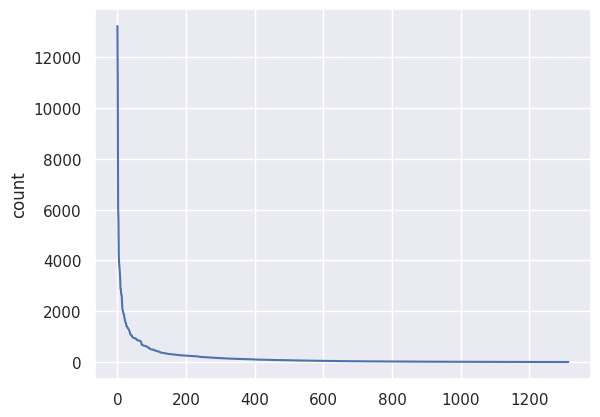

In [48]:
sns.set()
sns.lineplot(grouped_tags, x=grouped_tags.index, y='count')
plt.show()

In [49]:
common_tags = grouped_tags.iloc[:200]
common_tags.shape

(200, 2)

In [50]:
tags_df = tags_df.loc[tags_df['Tag'].isin(common_tags['Tag'])].reset_index().filter(['Id','Tag'])
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186876 entries, 0 to 186875
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      186876 non-null  int64 
 1   Tag     186876 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [51]:
regex = re.compile('<((?!>).)*>')
def remove_html_tags(text: str):
    return re.sub(regex, '',text)

def find_question_tags(s: str):
    return tags_df[tags_df['Id'] == s]['Tag'].values

questions_df['Text'] = (questions_df['Title'] + " " + questions_df['Body']).apply(remove_html_tags)
questions_df['Tags'] = questions_df['Id'].apply(find_question_tags)
questions_df = questions_df.filter(['Text','Tags'],axis=1)
questions_df.head(5)

,Text,Tags
0,The Two Cultures: statistics vs. machine learn...,[machine-learning]
1,Forecasting demographic census What are some o...,[forecasting]
2,Bayesian and frequentist reasoning in plain En...,[bayesian]
3,What is the meaning of p values and t values i...,"[hypothesis-testing, t-test, p-value, interpre..."
4,Examples for teaching: Correlation does not me...,[correlation]


In [52]:
multilabel_binarizer = MultiLabelBinarizer()
Y = pd.DataFrame(multilabel_binarizer.fit_transform(questions_df['Tags']))
X = questions_df['Text']

In [53]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [54]:
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(X_tfidf,Y,test_size=0.3,random_state=32)
print("train shape",X_train_tfidf.shape, Y_train.shape)
print("test shape", X_test_tfidf.shape, Y_test.shape)

train shape (59559, 267866) (59559, 200)
test shape (25526, 267866) (25526, 200)


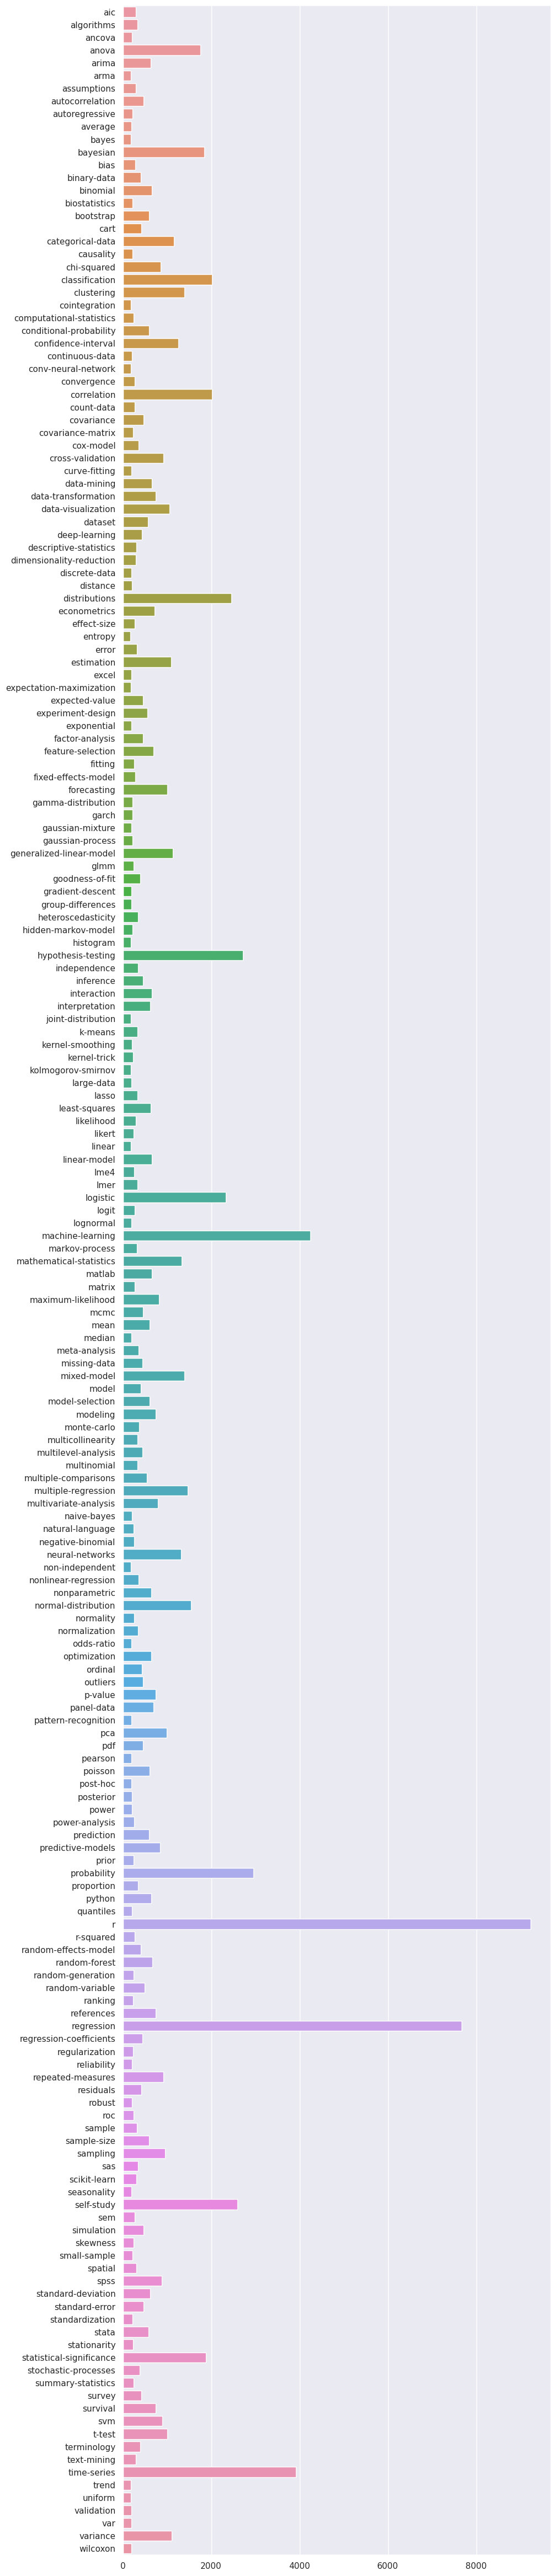

In [55]:
fig = plt.figure(figsize=(10,60))
sns.barplot(x=Y_train.sum(axis=0),y=multilabel_binarizer.classes_)
plt.show()

In [56]:
multinomial_nb = MultinomialNB()
sgd_classiffier = SGDClassifier()
logistic_regression = LogisticRegression()

In [57]:
classifiers = {
    'multinomial_nb': multinomial_nb,
    'sgd_classiffier': sgd_classiffier,
}

classifiers

{'multinomial_nb': MultinomialNB(), 'sgd_classiffier': SGDClassifier()}

In [58]:
def print_score(y_pred, name):
    print("Clf: ", name)
    print("Accuracy :",accuracy_score(Y_test, y_pred))
    print("Hamming loss ",hamming_loss(Y_test,y_pred))
    precision = precision_score(Y_test, y_pred, average='micro')
    recall = recall_score(Y_test, y_pred, average='micro')
    f1 = f1_score(Y_test, y_pred, average='micro')
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print('\n')

In [59]:
for name,classifier in classifiers.items():
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train_tfidf,Y_train)
    Y_pred = clf.predict(X_test_tfidf)
    print("One Vs Rest classifier:\n")
    print_score(Y_pred, name)
    # clf = ClassifierChain(classifier)
    # clf.fit(X_train_tfidf,Y_train)
    # Y_pred = clf.predict(X_test_tfidf)
    # print("\nChainClassifier:\n")
    # print_score(Y_pred, name)


One Vs Rest classifier:

Clf:  multinomial_nb
Accuracy : 0.04881297500587636
Hamming loss  0.011382120191177623
Micro-average quality numbers
Precision: 0.0602, Recall: 0.0026, F1-measure: 0.0049


One Vs Rest classifier:

Clf:  sgd_classiffier
Accuracy : 0.10217033612786962
Hamming loss  0.00967601661051477
Micro-average quality numbers
Precision: 0.7996, Recall: 0.1577, F1-measure: 0.2634


